# PDF Analysis Tutorial

## Introduction

This tutorial demonstrates how to acquire a multidimensional pair distribution function (PDF) from both a flat field electron diffraction pattern and a scanning electron diffraction data set.

The data is from an open-source paper by Shanmugam et al. [1] that is used as a reference standard. It is an
Amorphous 18nm SiO2 film. The scanning electron diffraction data set is a scan of a polycrystalline gold reference standard with 128x128 real space pixels and 256x256 diffraction space pixels. The implementation also initially followed Shanmugam et al.



[1] Shanmugam, J., Borisenko, K. B., Chou, Y. J., & Kirkland, A. I. (2017). eRDF Analyser: An interactive GUI for electron reduced density function analysis. SoftwareX, 6, 185-192.

This functionality has been checked to run in pyxem-0.13.0 (March 2021). Bugs are always possible, do not trust the code blindly, and if you experience any issues please report them here: https://github.com/pyxem/pyxem-demos/issues

## Contents

1. <a href='#loa'> Loading & Inspection</a>
2. <a href='#rad'> Acquiring a radial profile</a>
3. <a href='#ri'> Acquiring a Reduced Intensity</a>
4. <a href='#dri'> Damping the Reduced Intensity</a>
5. <a href='#pdf'> Acquiring a PDF</a>

Import pyXem and other required libraries

In [1]:
%matplotlib inline
import hyperspy.api as hs
import pyxem as pxm
import numpy as np

ERROR:numba.cuda.cudadrv.driver:Call to cuInit results in CUDA_ERROR_NO_DEVICE


<a id='loa'></a>

##  1. Loading and Inspection

Load the diffraction data line profile

In [2]:
rp = hs.load('./data/08/amorphousSiO2.hspy')

In [3]:
rp.set_signal_type('electron_diffraction')

For now, the code requires navigation dimensions in the reduced intensity signal, two size 1 ones are created.

In [4]:
rp = pxm.signals.ElectronDiffraction1D([[rp.data]])

Set the diffraction pattern calibration. Note that pyXem uses a calibration to $s = \frac{1}{d} = 2\frac{\sin{\theta}}{\lambda}$.

In [5]:
calibration = 0.00167

rp.set_diffraction_calibration(calibration=calibration)

Plot the radial profile 

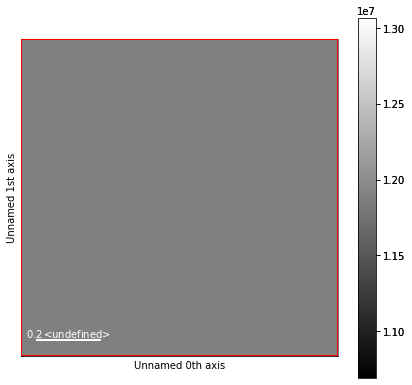

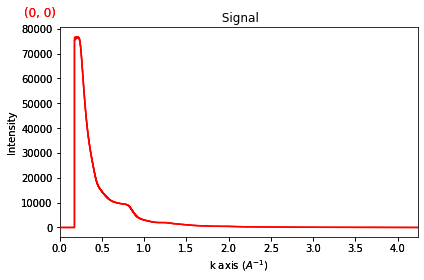

In [6]:
rp.plot()

<a id='ri'></a>

##  2. Acquiring a Reduced Intensity

Acquire a reduced intensity (also called a structure factor) from the radial profile. The structure factor is what will subsequently be transformed into a PDF through a fourier transform.

The structure factor $\phi(s)$ is acquired by fitting a background scattering factor to the data, and then transforming the data by: 

$$\phi(s) = \frac{I(s) - N\Delta c_{i}f_{i}^{2}}{N\Delta c_{i}^{2}f_{i}^{2}}$$

where s is the scattering vecot, $c_{i}$ and $f_{i}$ the atomic fraction and scattering factor respectively of each element in the sample, and N is a fitted parameter to the intensity.

To acquire the reduced intensity, we first initialise a ReducedIntensityGenerator1D object.

In [7]:
rigen = pxm.generators.ReducedIntensityGenerator1D(rp)

We then fit an electron scattering factor to the profile. To do this, we need to define a list of elements and their respective atomic fractions.

In [8]:
elements = ['Si','O']
fracs = [0.333,0.667]

Then we will fit a background scattering factor. The scattering factor parametrisation used here is that specified by Lobato and Van Dyck [2]. The plot_fit parameter ensures we check the fitted profile.

[2] Lobato, I., & Van Dyck, D. (2014). An accurate parameterization for scattering factors, electron densities and electrostatic potentials for neutral atoms that obey all physical constraints. Acta Crystallographica Section A: Foundations and Advances, 70(6), 636-649.

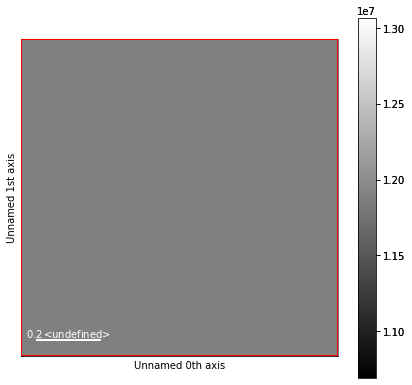

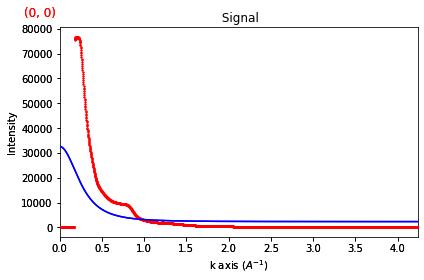

In [9]:
rigen.fit_atomic_scattering(elements,fracs,scattering_factor='lobato',plot_fit=True,iterpath='serpentine')

That's clearly a terrible fit! This is because we're trying to fit the beam stop. To avoid this, we specify to fit to the 'tail end' of the data by specifying a minimum and maximum scattering angle range. This is generally recommended, as electron scattering factors tend to not include inelastic scattering, which means the factors are rarely perfect fits.

In [10]:
rigen.set_s_cutoff(s_min=1.5,s_max=4)

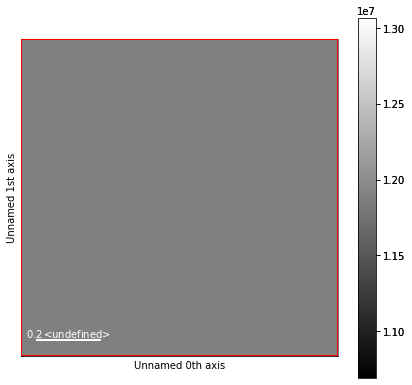

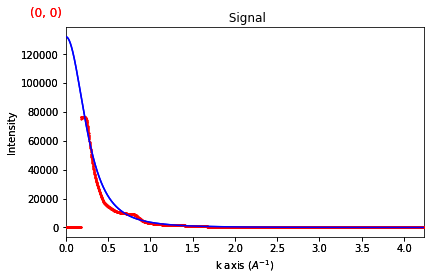

In [11]:
rigen.fit_atomic_scattering(elements,fracs,scattering_factor='lobato',plot_fit=True,iterpath='serpentine')

That's clearly much much better. Always inspect your fit.

Finally, we calculate the reduced intensity itself.

In [12]:
ri = rigen.get_reduced_intensity()

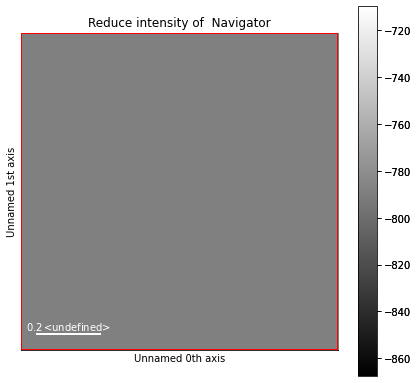

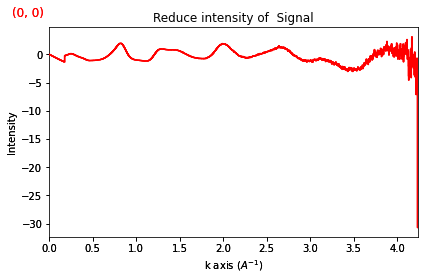

In [13]:
ri.plot()

If it seems like the reduced intensity is not oscillating around 0 at high s, you should try fitting with a larger s_min. This generally speaking solves the issue.

<a id='dri'></a> 

## 4. Damping the Reduced Intensity

The reduced intensity acquired above does not go to zero at high s as it should because the maximum acquired scattering vector is not very high.

This would result in significant oscillation in the PDF due to a discontinuity in the fourier transformed data. To combat this, the reduced intensity is damped. In the X-ray community a common damping functions are the Lorch function and an exponential damping function. Both are supported here.

It is worth noting that damping does reduce the resolution in r in the PDF.

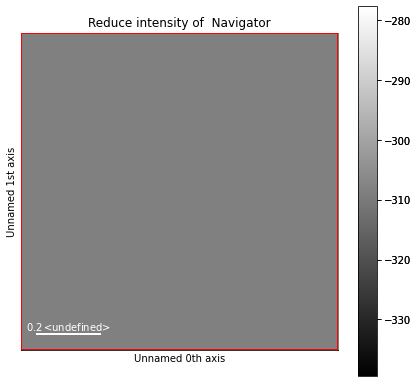

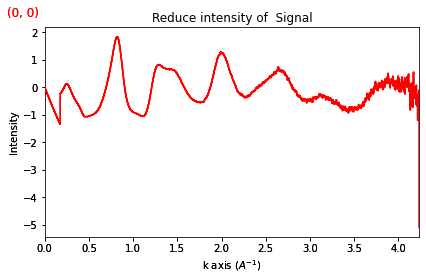

In [14]:
ri.damp_exponential(b=0.1)
ri.plot()

/home/carter/anaconda3/lib/python3.7/site-packages/pyxem/utils/ri_utils.py:118: RuntimeWarning: invalid value encountered in true_divide
  damping_term = np.sin(delta * scattering_axis) / (delta * scattering_axis)


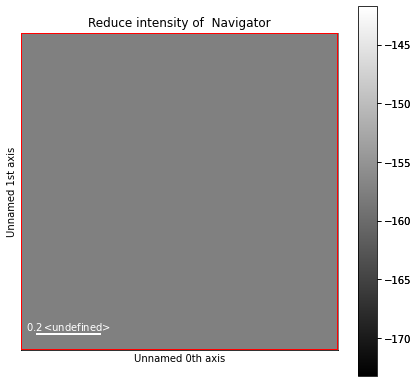

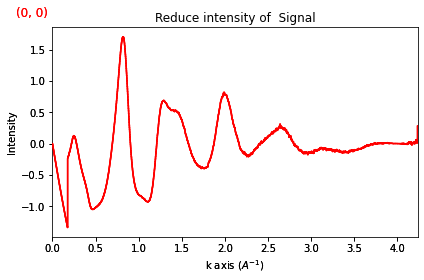

In [15]:
ri.damp_lorch(s_max=4)
ri.plot()

Additionally, it is recommended to damp the low s regime. We use an error function to do that 

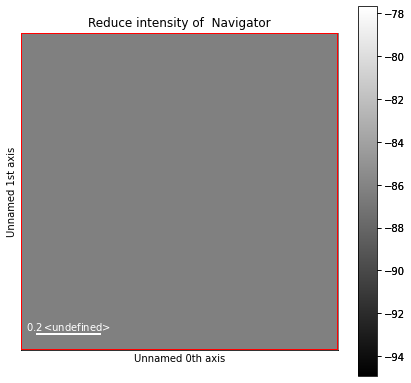

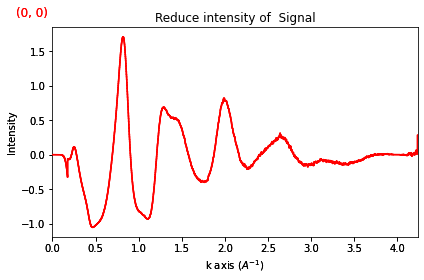

In [16]:
ri.damp_low_q_region_erfc(offset=4)
ri.plot()

If the function ends up overdamped, you can simply reacquire the reduced intensity using:

In [17]:
ri = rigen.get_reduced_intensity()

<a id='pdf'></a> 

## 5. Acquiring a PDF

Finally, a PDF is acquired from the damped reduced intensity. This is done by a fourier sine transform. 
To ignore parts of the scattering data that are too noisy, you can set a minimum and maximum scattering angle for the transform.

First, we initialise a PDFGenerator1D object.

In [18]:
pdfgen = pxm.generators.PDFGenerator1D(ri)

Secify a minimum and maximum scattering angle. The maximum must be equivalent to the Lorch function s_max if the Lorch function is used to damp. Otherwise the Lorch function damping can cause artifact in the PDF.

In [19]:
s_min = 0.
s_max = 4.

Finally we get the PDF. r_max specifies the maximum real space distance we want to interpret.

In [20]:
pdf = pdfgen.get_pdf(s_min=s_min, s_max=s_max, r_max=10)

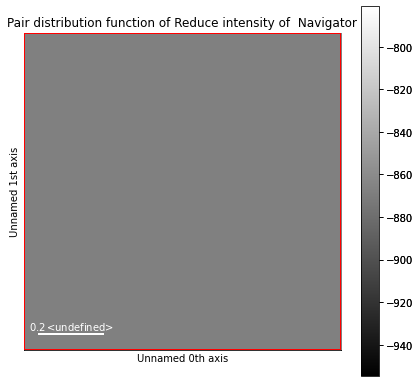

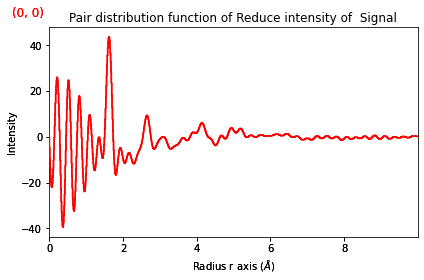

In [21]:
pdf.plot()

The PDF can then be saved.

In [22]:
pdf.save('Demo-PDF.hspy')